# An Analysis of EPC Data for Postcodes that Begin with DH1

X is a climate tech start-up that deals with residential clients, solving problems ranging from lack of photovoltaic supply to heat pump solutions. The purpose of this case study is to

1. Choose a sample of domestic homes in the UK via EPC data
2. Form a demographic analysis for these homes
3. Select a "near-ideal"* prospect client$^*$ for the case study
4. Produce visualizations based on the top customer's data, with the theme of displaying how much value we would bring to their home-efficiency.


$^*$ The process and metrics used to rank clients will be elaborated below.

$^*$ The ideal client is someone who has the largest gap between current energy efficiency and potential energy efficiency, as this highlights the significant potential for improvement in their energy rating.

## **I** Data Preparation

The first section of this notebook is concerned with importing and cleaning the data, making it ready for analysis. I begin by importing the relevant data from [the UK Gov's EPC data](https://www.gov.uk/find-energy-certificate). I initially choose houses that begin with the postcode DH1 (Durham) because Durham, a small town in the north-east is a high potential area with an above average energy effieiency rating of 63.3 (D) yet has potential to reach an effiecency rating of 81.6 (B).

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
#Importing Necessary Libraries

import pandas as pd #Pandas to load and handle the data
import numpy as np #Numpy for some extra math tools
import matplotlib.pyplot as plt #For visualizations
import seaborn as sns #For visualizations

In [44]:
# Load the datasets
certificates = pd.read_csv('/content/drive/MyDrive/epc-certificates/certificates.csv')
recommendations = pd.read_csv('/content/drive/MyDrive/epc-certificates/recommendations.csv')

In [46]:
certificates.shape

(5000, 92)

As shown above, the dataframe above has dimensions 5000x92. The 5000 rows represent the 5000 houses collected in the sample, and the 92 columns represent all the datapoints on each home. One can likely notice that there are a lot of columns that are irrelevant to this report, and also a lot of anomalies such as NaNs. For this reason, to increase efficiency and simplicity of the data analysis, I will clean the data by

*   Identify and fix anomalies
*   Understand Numerical and Categorical features
*   Adding a column called `IMPROVEMENT_DELTA` which gets the difference in the house's current efficiency and the house's potential efficiency.





In [47]:
# Lets look at the recommendations data
recommendations.head()

,LMK_KEY,IMPROVEMENT_ITEM,IMPROVEMENT_SUMMARY_TEXT,IMPROVEMENT_DESCR_TEXT,IMPROVEMENT_ID,IMPROVEMENT_ID_TEXT,INDICATIVE_COST
0,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,1,Room-in-roof insulation,Room-in-roof insulation,46.0,NaN,"£1,500 - £2,700"
1,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,2,Internal or external wall insulation,Internal or external wall insulation,7.0,NaN,"£4,000 - £14,000"
2,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,3,Floor insulation (suspended floor),Floor insulation (suspended floor),57.0,NaN,"£800 - £1,200"
3,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,4,Draught proofing,Draught proofing,10.0,NaN,£80 - £120
4,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,5,Solar water heating,Solar water heating,19.0,NaN,"£4,000 - £6,000"


In [48]:
recommendations.shape

(19810, 7)

In [49]:
recommendations.isna().sum() #Nbr of NaN anomalies per Column

LMK_KEY                         0
IMPROVEMENT_ITEM                0
IMPROVEMENT_SUMMARY_TEXT        0
IMPROVEMENT_DESCR_TEXT          0
IMPROVEMENT_ID                  0
IMPROVEMENT_ID_TEXT         19810
INDICATIVE_COST                 0
dtype: int64

As shown above, the dataframe above has dimensions 19810x7. The 19810 rows represent multiple recommendations for the different houses that are identified by `LMK_KEY`. For this reason, data cleansing will not take part for this file. As we are only interested in the `LMK_KEY`, `IMPROVEMENT_ITEM`, and `INDICATIVE_COST`, they do not contain any null values.

### Data Exploration

In [50]:
# I want to get an overview of missing data and invalid entries
missing_data_summary = certificates.isnull().sum()
invalid_entries_summary = certificates.apply(lambda x: x.isin(['INVALID', 'NO DATA!', 'N/A', 'Not recorded']).sum())

# Adjust pandas display options (so I don't see any truncation)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Display the summaries
print("Missing Data Summary:")
print(missing_data_summary)

print("\nInvalid Entries Summary:")
print(invalid_entries_summary)

Missing Data Summary:
LMK_KEY                             0
ADDRESS1                            0
ADDRESS2                         3737
ADDRESS3                         4886
POSTCODE                            0
BUILDING_REFERENCE_NUMBER           0
CURRENT_ENERGY_RATING               0
POTENTIAL_ENERGY_RATING             0
CURRENT_ENERGY_EFFICIENCY           0
POTENTIAL_ENERGY_EFFICIENCY         0
PROPERTY_TYPE                       0
BUILT_FORM                          0
INSPECTION_DATE                     0
LOCAL_AUTHORITY                     7
CONSTITUENCY                        0
COUNTY                           5000
LODGEMENT_DATE                      0
TRANSACTION_TYPE                    0
ENVIRONMENT_IMPACT_CURRENT          0
ENVIRONMENT_IMPACT_POTENTIAL        0
ENERGY_CONSUMPTION_CURRENT          0
ENERGY_CONSUMPTION_POTENTIAL        0
CO2_EMISSIONS_CURRENT               0
CO2_EMISS_CURR_PER_FLOOR_AREA       0
CO2_EMISSIONS_POTENTIAL             0
LIGHTING_COST_CURRENT       

In [51]:
# Function to create scrollable table within a small window
# Reference for function 'create_scrollable_table': https://www.kaggle.com/code/starfanstarfan/time-spent-on-social-media-by-generations
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [52]:
numerical_features = certificates.select_dtypes(include=[np.number])
numerical_features.describe()

,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,COUNTY,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,CO2_EMISSIONS_POTENTIAL,LIGHTING_COST_CURRENT,LIGHTING_COST_POTENTIAL,HEATING_COST_CURRENT,HEATING_COST_POTENTIAL,HOT_WATER_COST_CURRENT,HOT_WATER_COST_POTENTIAL,TOTAL_FLOOR_AREA,FLAT_STOREY_COUNT,MAIN_HEATING_CONTROLS,MULTI_GLAZE_PROPORTION,EXTENSION_COUNT,NUMBER_HABITABLE_ROOMS,NUMBER_HEATED_ROOMS,LOW_ENERGY_LIGHTING,NUMBER_OPEN_FIREPLACES,SHEATING_ENERGY_EFF,SHEATING_ENV_EFF,WIND_TURBINE_COUNT,UNHEATED_CORRIDOR_LENGTH,FLOOR_HEIGHT,PHOTO_SUPPLY,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN
count,5.000000e+03,5000.00000,5000.000000,0.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,0.0,1800.000000,4738.000000,4386.000000,4386.000000,4386.000000,5000.00000,5000.000000,0.0,0.0,4738.0,0.0,2938.000000,2546.000000,3200.000000,616.000000,4.950000e+03
mean,7.809450e+09,67.82680,83.676200,NaN,64.085200,81.062400,223.510000,112.882400,4.151260,39.480800,2.220860,104.117600,90.50060,863.796000,686.706600,141.512400,88.98020,109.27400,NaN,2114.130000,94.110173,0.856361,5.327405,5.283174,80.18760,0.060400,NaN,NaN,0.0,NaN,2.432119,1.100550,14.139062,13.779221,8.919190e+10
std,3.147758e+09,10.00004,5.782356,NaN,12.443653,7.842679,84.644305,45.157307,2.434558,15.262366,1.570132,46.305138,38.11517,670.284101,469.618733,104.129145,47.10763,61.48708,NaN,58.798464,20.822067,0.881523,1.523053,1.540950,27.21122,0.325535,NaN,NaN,0.0,NaN,0.198799,6.566159,9.123670,11.512028,4.829732e+10
min,1.272568e+06,15.00000,43.000000,NaN,11.000000,36.000000,-10.000000,-126.000000,-0.300000,-2.000000,-1.400000,19.000000,19.00000,81.000000,101.000000,58.000000,34.00000,14.00000,NaN,2101.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,NaN,NaN,0.0,NaN,1.000000,0.000000,1.000000,0.000000,1.000101e+10
25%,5.729152e+09,62.00000,80.000000,NaN,57.000000,77.000000,178.000000,92.000000,2.800000,31.000000,1.400000,74.000000,67.00000,526.000000,446.750000,91.000000,64.00000,79.00000,NaN,2106.000000,100.000000,0.000000,4.000000,4.000000,67.00000,0.000000,NaN,NaN,0.0,NaN,2.350000,0.000000,10.000000,9.000000,1.001104e+11
50%,1.000072e+10,68.00000,83.000000,NaN,64.000000,81.000000,223.000000,117.000000,3.700000,39.000000,1.900000,93.000000,80.00000,699.000000,568.000000,105.000000,72.00000,95.00000,NaN,2106.000000,100.000000,1.000000,5.000000,5.000000,96.00000,0.000000,NaN,NaN,0.0,NaN,2.410000,0.000000,12.000000,13.000000,1.001104e+11
75%,1.000346e+10,73.00000,86.000000,NaN,71.000000,85.000000,268.000000,137.000000,4.900000,47.000000,2.700000,123.000000,102.00000,1004.250000,789.250000,153.000000,99.00000,123.00000,NaN,2106.000000,100.000000,1.000000,6.000000,6.000000,100.00000,0.000000,NaN,NaN,0.0,NaN,2.500000,0.000000,16.000000,16.000000,1.001104e+11
max,1.000596e+10,102.00000,118.000000,NaN,102.000000,117.000000,721.000000,316.000000,61.000000,148.000000,37.000000,925.000000,551.00000,15900.000000,11358.000000,2617.000000,463.00000,1773.00000,NaN,2706.000000,100.000000,4.000000,18.000000,18.000000,100.00000,6.000000,NaN,NaN,0.0,NaN,5.000000,90.000000,220.000000,198.000000,2.000032e+11


In [53]:
from IPython.display import display, HTML

# Summary statistics for numerical features
numerical_features = certificates.select_dtypes(include=[np.number])
summary_stats = numerical_features.describe()
# summary_stats = numerical_features.describe().T
html_numerical = create_scrollable_table(summary_stats, 'numerical_features', 'Summary statistics for numerical features')

display(HTML(html_numerical))

,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,COUNTY,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,CO2_EMISSIONS_POTENTIAL,LIGHTING_COST_CURRENT,LIGHTING_COST_POTENTIAL,HEATING_COST_CURRENT,HEATING_COST_POTENTIAL,HOT_WATER_COST_CURRENT,HOT_WATER_COST_POTENTIAL,TOTAL_FLOOR_AREA,FLAT_STOREY_COUNT,MAIN_HEATING_CONTROLS,MULTI_GLAZE_PROPORTION,EXTENSION_COUNT,NUMBER_HABITABLE_ROOMS,NUMBER_HEATED_ROOMS,LOW_ENERGY_LIGHTING,NUMBER_OPEN_FIREPLACES,SHEATING_ENERGY_EFF,SHEATING_ENV_EFF,WIND_TURBINE_COUNT,UNHEATED_CORRIDOR_LENGTH,FLOOR_HEIGHT,PHOTO_SUPPLY,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN
count,5.000000e+03,5000.00000,5000.000000,0.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,0.0,1800.000000,4738.000000,4386.000000,4386.000000,4386.000000,5000.00000,5000.000000,0.0,0.0,4738.0,0.0,2938.000000,2546.000000,3200.000000,616.000000,4.950000e+03
mean,7.809450e+09,67.82680,83.676200,NaN,64.085200,81.062400,223.510000,112.882400,4.151260,39.480800,2.220860,104.117600,90.50060,863.796000,686.706600,141.512400,88.98020,109.27400,NaN,2114.130000,94.110173,0.856361,5.327405,5.283174,80.18760,0.060400,NaN,NaN,0.0,NaN,2.432119,1.100550,14.139062,13.779221,8.919190e+10
std,3.147758e+09,10.00004,5.782356,NaN,12.443653,7.842679,84.644305,45.157307,2.434558,15.262366,1.570132,46.305138,38.11517,670.284101,469.618733,104.129145,47.10763,61.48708,NaN,58.798464,20.822067,0.881523,1.523053,1.540950,27.21122,0.325535,NaN,NaN,0.0,NaN,0.198799,6.566159,9.123670,11.512028,4.829732e+10
min,1.272568e+06,15.00000,43.000000,NaN,11.000000,36.000000,-10.000000,-126.000000,-0.300000,-2.000000,-1.400000,19.000000,19.00000,81.000000,101.000000,58.000000,34.00000,14.00000,NaN,2101.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,NaN,NaN,0.0,NaN,1.000000,0.000000,1.000000,0.000000,1.000101e+10
25%,5.729152e+09,62.00000,80.000000,NaN,57.000000,77.000000,178.000000,92.000000,2.800000,31.000000,1.400000,74.000000,67.00000,526.000000,446.750000,91.000000,64.00000,79.00000,NaN,2106.000000,100.000000,0.000000,4.000000,4.000000,67.00000,0.000000,NaN,NaN,0.0,NaN,2.350000,0.000000,10.000000,9.000000,1.001104e+11
50%,1.000072e+10,68.00000,83.000000,NaN,64.000000,81.000000,223.000000,117.000000,3.700000,39.000000,1.900000,93.000000,80.00000,699.000000,568.000000,105.000000,72.00000,95.00000,NaN,2106.000000,100.000000,1.000000,5.000000,5.000000,96.00000,0.000000,NaN,NaN,0.0,NaN,2.410000,0.000000,12.000000,13.000000,1.001104e+11
75%,1.000346e+10,73.00000,86.000000,NaN,71.000000,85.000000,268.000000,137.000000,4.900000,47.000000,2.700000,123.000000,102.00000,1004.250000,789.250000,153.000000,99.00000,123.00000,NaN,2106.000000,100.000000,1.000000,6.000000,6.000000,100.00000,0.000000,NaN,NaN,0.0,NaN,2.500000,0.000000,16.000000,16.000000,1.001104e+11
max,1.000596e+10,102.00000,118.000000,NaN,102.000000,117.000000,721.000000,316.000000,61.000000,148.000000,37.000000,925.000000,551.00000,15900.000000,11358.000000,2617.000000,463.00000,1773.00000,NaN,2706.000000,100.000000,4.000000,18.000000,18.000000,100.00000,6.000000,NaN,NaN,0.0,NaN,5.000000,90.000000,220.000000,198.000000,2.000032e+11


The dataset indicates that the average current energy efficiency rating of the buildings is 67.83, with potential improvements raising it to 83.68, suggesting significant opportunities for enhanced energy performance. Correspondingly, the average CO2 emissions could be reduced from 4.15 to 2.22, highlighting the environmental benefits of adopting energy efficiency measures.

**I realize here a few key points:**


*   CURRENT_ENERGY_EFFICIENCY and POTENTIAL_ENERGY_EFFICIENCY: These columns represent the current and potential energy efficiency ratings of the buildings.
 * The mean current efficiency is around 67.83, while the potential is higher at 83.68.
*   ENVIRONMENT_IMPACT_CURRENT and ENVIRONMENT_IMPACT_POTENTIAL: These columns represent the current and potential environmental impact scores.
 * Similar trends to energy efficiency, with potential scores higher than current ones.
* ENERGY_CONSUMPTION_CURRENT and ENERGY_CONSUMPTION_POTENTIAL:

 * Standard deviations: 84.644305 and 45.157307, respectively.
These high standard deviations indicate significant differences in energy consumption among the buildings.

* Also some columns had similar trends to energy efficiency

* Some columns with high standard deviations, such as heating costs, energy consumption, and CO2 emissions per floor area, highlight areas where there is substantial variation in the data

* Several columns have ranges or values that seem unusual (e.g negative values for energy consumption) that suggests a need for data cleaning or validation

In [54]:
# Summary statistics for categorical features
categorical_features = certificates.select_dtypes(include=[object])
cat_summary_stats = categorical_features.describe().T
html_categorical = create_scrollable_table(cat_summary_stats, 'categorical_features', 'Summary statistics for categorical features')

display(HTML(html_categorical ))

,count,unique,top,freq
LMK_KEY,5000,5000,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,1
ADDRESS1,5000,4790,110 Thorndale Road,4
ADDRESS2,1263,182,Pity Me,141
ADDRESS3,114,28,DURHAM,39
POSTCODE,5000,767,DH1 1GZ,60
CURRENT_ENERGY_RATING,5000,7,D,2204
POTENTIAL_ENERGY_RATING,5000,5,B,3144
PROPERTY_TYPE,5000,1,House,5000
BUILT_FORM,5000,6,Semi-Detached,1801
INSPECTION_DATE,5000,1464,2022-08-22,205


The categorical features in the dataset provide detailed information about the properties, including their addresses, energy ratings, and structural characteristics. For example, most properties are classified as "House" (100%), with a common energy rating of "D" currently and potential rating of "B", indicating a scope for energy efficiency improvements.

In [55]:
certificates.columns

Index(['LMK_KEY', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'POSTCODE', 'BUILDING_REFERENCE_NUMBER',
       'CURRENT_ENERGY_RATING', 'POTENTIAL_ENERGY_RATING', 'CURRENT_ENERGY_EFFICIENCY',
       'POTENTIAL_ENERGY_EFFICIENCY', 'PROPERTY_TYPE', 'BUILT_FORM', 'INSPECTION_DATE',
       'LOCAL_AUTHORITY', 'CONSTITUENCY', 'COUNTY', 'LODGEMENT_DATE', 'TRANSACTION_TYPE',
       'ENVIRONMENT_IMPACT_CURRENT', 'ENVIRONMENT_IMPACT_POTENTIAL', 'ENERGY_CONSUMPTION_CURRENT',
       'ENERGY_CONSUMPTION_POTENTIAL', 'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA',
       'CO2_EMISSIONS_POTENTIAL', 'LIGHTING_COST_CURRENT', 'LIGHTING_COST_POTENTIAL',
       'HEATING_COST_CURRENT', 'HEATING_COST_POTENTIAL', 'HOT_WATER_COST_CURRENT',
       'HOT_WATER_COST_POTENTIAL', 'TOTAL_FLOOR_AREA', 'ENERGY_TARIFF', 'MAINS_GAS_FLAG',
       'FLOOR_LEVEL', 'FLAT_TOP_STOREY', 'FLAT_STOREY_COUNT', 'MAIN_HEATING_CONTROLS',
       'MULTI_GLAZE_PROPORTION', 'GLAZED_TYPE', 'GLAZED_AREA', 'EXTENSION_COUNT',
       'NUMBER_

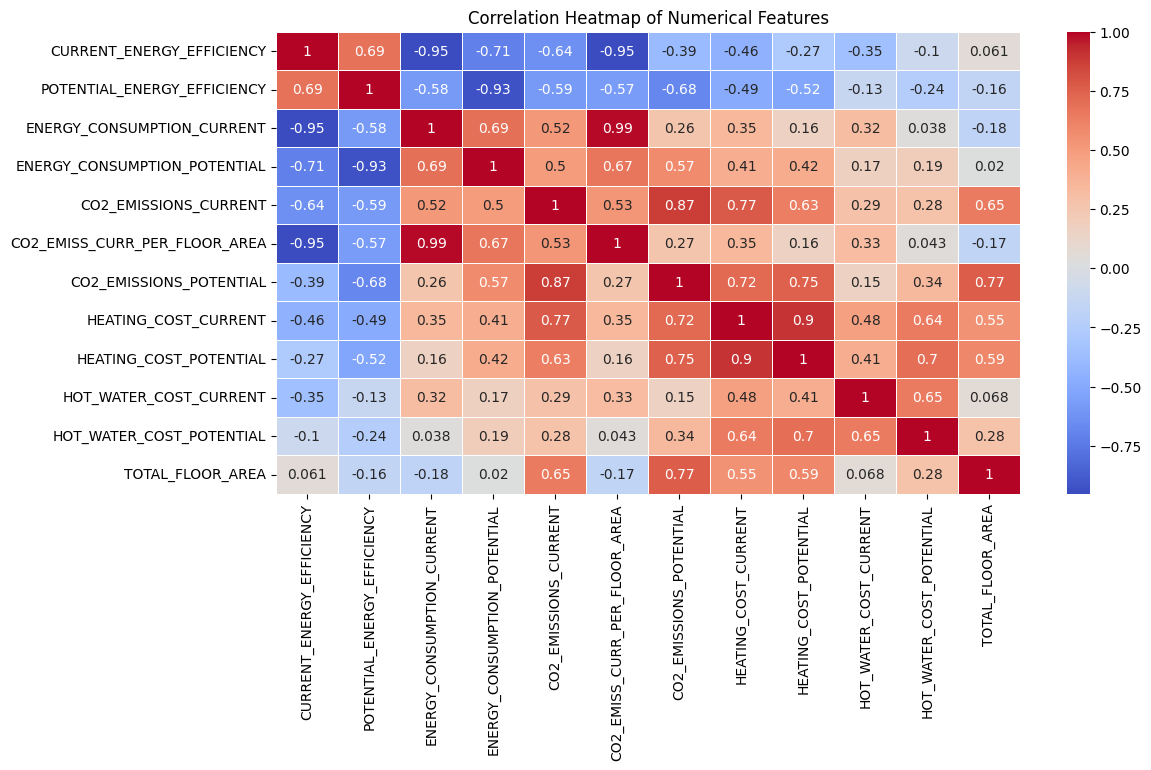

In [56]:
# Select numerical columns for the correlation matrix
numerical_columns = ['CURRENT_ENERGY_EFFICIENCY', 'POTENTIAL_ENERGY_EFFICIENCY',
                     'ENERGY_CONSUMPTION_CURRENT', 'ENERGY_CONSUMPTION_POTENTIAL',
                     'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA',
                     'CO2_EMISSIONS_POTENTIAL', 'HEATING_COST_CURRENT',
                     'HEATING_COST_POTENTIAL', 'HOT_WATER_COST_CURRENT',
                     'HOT_WATER_COST_POTENTIAL', 'TOTAL_FLOOR_AREA']

# Calculate the correlation matrix
correlation_matrix = certificates[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## Data Cleaning

In [57]:
# Convert date columns to datetime
certificates['INSPECTION_DATE'] = pd.to_datetime(certificates['INSPECTION_DATE'], errors='coerce')
certificates['LODGEMENT_DATE'] = pd.to_datetime(certificates['LODGEMENT_DATE'], errors='coerce')

# Identify numerical columns
numerical_columns = ['CURRENT_ENERGY_EFFICIENCY', 'POTENTIAL_ENERGY_EFFICIENCY',
                     'ENERGY_CONSUMPTION_CURRENT', 'ENERGY_CONSUMPTION_POTENTIAL',
                     'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA',
                     'CO2_EMISSIONS_POTENTIAL', 'HEATING_COST_CURRENT',
                     'HEATING_COST_POTENTIAL', 'HOT_WATER_COST_CURRENT',
                     'HOT_WATER_COST_POTENTIAL']

# Convert to numeric and handle errors
for column in numerical_columns:
    certificates[column] = pd.to_numeric(certificates[column], errors='coerce')

# Fill numerical NaN values with the median
for column in numerical_columns:
    median_value = certificates[column].median()
    certificates[column].fillna(median_value, inplace=True)

# Identify categorical columns
categorical_columns = ['CURRENT_ENERGY_RATING', 'POTENTIAL_ENERGY_RATING',
                       'PROPERTY_TYPE', 'BUILT_FORM', 'TRANSACTION_TYPE',
                       'FLOOR_LEVEL', 'FLAT_TOP_STOREY', 'FLAT_STOREY_COUNT',
                       'MAIN_HEATING_CONTROLS', 'GLAZED_TYPE', 'GLAZED_AREA',
                       'MAINHEAT_DESCRIPTION', 'MAINHEAT_ENERGY_EFF',
                       'MAINHEAT_ENV_EFF', 'MAINHEATCONT_DESCRIPTION',
                       'MAINHEATC_ENERGY_EFF', 'MAINHEATC_ENV_EFF',
                       'LIGHTING_DESCRIPTION', 'LIGHTING_ENERGY_EFF',
                       'LIGHTING_ENV_EFF', 'MAIN_FUEL', 'HEAT_LOSS_CORRIDOR',
                       'SOLAR_WATER_HEATING_FLAG', 'MECHANICAL_VENTILATION',
                       'CONSTRUCTION_AGE_BAND', 'TENURE']

# Fill missing values in categorical columns with 'Unknown'
for column in categorical_columns:
    certificates[column].fillna('Unknown', inplace=True)

In [58]:
# Identify columns with all NaN values
all_nan_columns = certificates.columns[certificates.isnull().all()]
print("Columns with all NaN values:")
print(all_nan_columns)

Columns with all NaN values:
Index(['COUNTY', 'SHEATING_ENERGY_EFF', 'SHEATING_ENV_EFF', 'UNHEATED_CORRIDOR_LENGTH'], dtype='object')


In [59]:
# Drop columns with all NaN values
cert_cleaned = certificates.drop(columns=all_nan_columns)

In [60]:
# Drop rows with NaN in any of the critical columns that should not have missing values
critical_columns = ['CURRENT_ENERGY_EFFICIENCY', 'POTENTIAL_ENERGY_EFFICIENCY',
                    'ENERGY_CONSUMPTION_CURRENT', 'ENERGY_CONSUMPTION_POTENTIAL',
                    'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA',
                    'CO2_EMISSIONS_POTENTIAL', 'HEATING_COST_CURRENT',
                    'HEATING_COST_POTENTIAL', 'HOT_WATER_COST_CURRENT',
                    'HOT_WATER_COST_POTENTIAL']

cert_cleaned = cert_cleaned.dropna(subset=critical_columns)

In [61]:
# Summary of missing data after cleaning
cleaned_missing_data_summary = cert_cleaned.isnull().sum()
print("Cleaned Missing Data Summary:")
# print(cleaned_missing_data_summary)

# Compare with the initial summary
print("\nComparison of Initial and Cleaned Data Summaries:")
comparison = pd.DataFrame({
    'Initial': missing_data_summary,
    'Cleaned': cleaned_missing_data_summary
})
print(comparison)


Cleaned Missing Data Summary:

Comparison of Initial and Cleaned Data Summaries:
                               Initial  Cleaned
ADDRESS                              0      0.0
ADDRESS1                             0      0.0
ADDRESS2                          3737   3737.0
ADDRESS3                          4886   4886.0
BUILDING_REFERENCE_NUMBER            0      0.0
BUILT_FORM                           0      0.0
CO2_EMISSIONS_CURRENT                0      0.0
CO2_EMISSIONS_POTENTIAL              0      0.0
CO2_EMISS_CURR_PER_FLOOR_AREA        0      0.0
CONSTITUENCY                         0      0.0
CONSTITUENCY_LABEL                   7      7.0
CONSTRUCTION_AGE_BAND               70      0.0
COUNTY                            5000      NaN
CURRENT_ENERGY_EFFICIENCY            0      0.0
CURRENT_ENERGY_RATING                0      0.0
ENERGY_CONSUMPTION_CURRENT           0      0.0
ENERGY_CONSUMPTION_POTENTIAL         0      0.0
ENERGY_TARIFF                        0      0.0
ENVIRON

In [62]:
# Identify columns with all NaN values
all_nan_columns = cert_cleaned.columns[cert_cleaned.isnull().all()]
print("Columns with all NaN values:")
print(all_nan_columns)

# Drop columns with all NaN values
cert_cleaned = cert_cleaned.drop(columns=all_nan_columns)

Columns with all NaN values:
Index([], dtype='object')


In [63]:
# Fill numerical NaN values with the median
numerical_columns = ['CURRENT_ENERGY_EFFICIENCY', 'POTENTIAL_ENERGY_EFFICIENCY',
                     'ENERGY_CONSUMPTION_CURRENT', 'ENERGY_CONSUMPTION_POTENTIAL',
                     'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA',
                     'CO2_EMISSIONS_POTENTIAL', 'HEATING_COST_CURRENT',
                     'HEATING_COST_POTENTIAL', 'HOT_WATER_COST_CURRENT',
                     'HOT_WATER_COST_POTENTIAL']

for column in numerical_columns:
    cert_cleaned[column] = pd.to_numeric(cert_cleaned[column], errors='coerce')
    if cert_cleaned[column].notna().any():  # Ensure there are non-NaN values
        median_value = cert_cleaned[column].median()
        cert_cleaned[column].fillna(median_value, inplace=True)

# Fill missing values in categorical columns with 'Unknown'
categorical_columns = ['CURRENT_ENERGY_RATING', 'POTENTIAL_ENERGY_RATING',
                       'PROPERTY_TYPE', 'BUILT_FORM', 'TRANSACTION_TYPE',
                       'FLOOR_LEVEL', 'FLAT_TOP_STOREY', 'FLAT_STOREY_COUNT',
                       'MAIN_HEATING_CONTROLS', 'GLAZED_TYPE', 'GLAZED_AREA',
                       'MAINHEAT_DESCRIPTION', 'MAINHEAT_ENERGY_EFF',
                       'MAINHEAT_ENV_EFF', 'MAINHEATCONT_DESCRIPTION',
                       'MAINHEATC_ENERGY_EFF', 'MAINHEATC_ENV_EFF',
                       'LIGHTING_DESCRIPTION', 'LIGHTING_ENERGY_EFF',
                       'LIGHTING_ENV_EFF', 'MAIN_FUEL', 'HEAT_LOSS_CORRIDOR',
                       'SOLAR_WATER_HEATING_FLAG', 'MECHANICAL_VENTILATION',
                       'CONSTRUCTION_AGE_BAND', 'TENURE']

for column in categorical_columns:
    cert_cleaned[column].fillna('Unknown', inplace=True)

In [64]:
# Drop rows where any of the critical columns still have NaN values
critical_columns = ['CURRENT_ENERGY_EFFICIENCY', 'POTENTIAL_ENERGY_EFFICIENCY',
                    'ENERGY_CONSUMPTION_CURRENT', 'ENERGY_CONSUMPTION_POTENTIAL',
                    'CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_FLOOR_AREA',
                    'CO2_EMISSIONS_POTENTIAL', 'HEATING_COST_CURRENT',
                    'HEATING_COST_POTENTIAL', 'HOT_WATER_COST_CURRENT',
                    'HOT_WATER_COST_POTENTIAL']

cert_cleaned = cert_cleaned.dropna(subset=critical_columns)

In [65]:
# Summary of missing data after cleaning
cleaned_missing_data_summary = cert_cleaned.isnull().sum()
print("Cleaned Missing Data Summary:")
print(cleaned_missing_data_summary)

# Compare with the initial summary
print("\nComparison of Initial and Cleaned Data Summaries:")
comparison = pd.DataFrame({
    'Initial': missing_data_summary,
    'Cleaned': cleaned_missing_data_summary
})
print(comparison)

Cleaned Missing Data Summary:
LMK_KEY                             0
ADDRESS1                            0
ADDRESS2                         3737
ADDRESS3                         4886
POSTCODE                            0
BUILDING_REFERENCE_NUMBER           0
CURRENT_ENERGY_RATING               0
POTENTIAL_ENERGY_RATING             0
CURRENT_ENERGY_EFFICIENCY           0
POTENTIAL_ENERGY_EFFICIENCY         0
PROPERTY_TYPE                       0
BUILT_FORM                          0
INSPECTION_DATE                     0
LOCAL_AUTHORITY                     7
CONSTITUENCY                        0
LODGEMENT_DATE                      0
TRANSACTION_TYPE                    0
ENVIRONMENT_IMPACT_CURRENT          0
ENVIRONMENT_IMPACT_POTENTIAL        0
ENERGY_CONSUMPTION_CURRENT          0
ENERGY_CONSUMPTION_POTENTIAL        0
CO2_EMISSIONS_CURRENT               0
CO2_EMISS_CURR_PER_FLOOR_AREA       0
CO2_EMISSIONS_POTENTIAL             0
LIGHTING_COST_CURRENT               0
LIGHTING_COST_POTENT

In [66]:
# Extract only numeric columns for checking negative values
numeric_df = cert_cleaned.select_dtypes(include=['number'])

# Check for negative values in the numeric columns
negative_values = numeric_df[numeric_df < 0].dropna(how='all')

# Count the number of negative values in each numeric column
negative_counts = (numeric_df < 0).sum()

# Display the count of negative values
print("Count of negative values in each numeric column:")
print(negative_counts)

Count of negative values in each numeric column:
BUILDING_REFERENCE_NUMBER         0
CURRENT_ENERGY_EFFICIENCY         0
POTENTIAL_ENERGY_EFFICIENCY       0
ENVIRONMENT_IMPACT_CURRENT        0
ENVIRONMENT_IMPACT_POTENTIAL      0
ENERGY_CONSUMPTION_CURRENT        1
ENERGY_CONSUMPTION_POTENTIAL     24
CO2_EMISSIONS_CURRENT             1
CO2_EMISS_CURR_PER_FLOOR_AREA     1
CO2_EMISSIONS_POTENTIAL          16
LIGHTING_COST_CURRENT             0
LIGHTING_COST_POTENTIAL           0
HEATING_COST_CURRENT              0
HEATING_COST_POTENTIAL            0
HOT_WATER_COST_CURRENT            0
HOT_WATER_COST_POTENTIAL          0
TOTAL_FLOOR_AREA                  0
MULTI_GLAZE_PROPORTION            0
EXTENSION_COUNT                   0
NUMBER_HABITABLE_ROOMS            0
NUMBER_HEATED_ROOMS               0
LOW_ENERGY_LIGHTING               0
NUMBER_OPEN_FIREPLACES            0
WIND_TURBINE_COUNT                0
FLOOR_HEIGHT                      0
PHOTO_SUPPLY                      0
FIXED_LIGHTING_

In [67]:
cert_cleaned = cert_cleaned[cert_cleaned['CO2_EMISSIONS_POTENTIAL'] >= 0]
cert_cleaned = cert_cleaned[cert_cleaned['ENERGY_CONSUMPTION_POTENTIAL'] >= 0]

In [68]:
# Extract only numeric columns for checking negative values
numeric_df = cert_cleaned.select_dtypes(include=['number'])

# Check for negative values in the numeric columns
negative_values = numeric_df[numeric_df < 0].dropna(how='all')

# Count the number of negative values in each numeric column
negative_counts = (numeric_df < 0).sum()

# Display the count of negative values
print("Count of negative values in each numeric column:")
print(negative_counts)

Count of negative values in each numeric column:
BUILDING_REFERENCE_NUMBER        0
CURRENT_ENERGY_EFFICIENCY        0
POTENTIAL_ENERGY_EFFICIENCY      0
ENVIRONMENT_IMPACT_CURRENT       0
ENVIRONMENT_IMPACT_POTENTIAL     0
ENERGY_CONSUMPTION_CURRENT       0
ENERGY_CONSUMPTION_POTENTIAL     0
CO2_EMISSIONS_CURRENT            0
CO2_EMISS_CURR_PER_FLOOR_AREA    0
CO2_EMISSIONS_POTENTIAL          0
LIGHTING_COST_CURRENT            0
LIGHTING_COST_POTENTIAL          0
HEATING_COST_CURRENT             0
HEATING_COST_POTENTIAL           0
HOT_WATER_COST_CURRENT           0
HOT_WATER_COST_POTENTIAL         0
TOTAL_FLOOR_AREA                 0
MULTI_GLAZE_PROPORTION           0
EXTENSION_COUNT                  0
NUMBER_HABITABLE_ROOMS           0
NUMBER_HEATED_ROOMS              0
LOW_ENERGY_LIGHTING              0
NUMBER_OPEN_FIREPLACES           0
WIND_TURBINE_COUNT               0
FLOOR_HEIGHT                     0
PHOTO_SUPPLY                     0
FIXED_LIGHTING_OUTLETS_COUNT     0
LOW_EN

As shown above, the new dataframe is much cleaner. While it still has a large number of anomalies in a few columns, this will prove to be a non-issue in the following sections. As the columns that will be used, show no to little anomalies.

After I clean the dataframe, I addded the `IMPROVEMENT_DELTA` column where $\Delta =$ Potential - Current.

In [69]:
current = cert_cleaned["CURRENT_ENERGY_EFFICIENCY"]
potential = cert_cleaned["POTENTIAL_ENERGY_EFFICIENCY"]
IMPROVEMENT_DELTA = potential - current #Defining the improvement delta column

cert_cleaned["IMPROVEMENT_DELTA"] = IMPROVEMENT_DELTA #Adding it to certificates


# Move the "IMPROVEMENT_DELTA" column to the right of "POTENTIAL_ENERGY_EFFICIENCY"
cols = list(cert_cleaned.columns)
cols.remove("IMPROVEMENT_DELTA")
cols.insert(cols.index("POTENTIAL_ENERGY_EFFICIENCY") + 1, "IMPROVEMENT_DELTA")
cert_cleaned = cert_cleaned[cols]

For a final touch, I sort the rows by increasing to decreasing order of $\Delta$

In [70]:
#sort the data frame by difference in descending order

cert_cleaned.sort_values(by="IMPROVEMENT_DELTA", inplace=True, ascending=False)
cert_cleaned.head()

,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,IMPROVEMENT_DELTA,PROPERTY_TYPE,BUILT_FORM,INSPECTION_DATE,LOCAL_AUTHORITY,CONSTITUENCY,LODGEMENT_DATE,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,CO2_EMISSIONS_POTENTIAL,LIGHTING_COST_CURRENT,LIGHTING_COST_POTENTIAL,HEATING_COST_CURRENT,HEATING_COST_POTENTIAL,HOT_WATER_COST_CURRENT,HOT_WATER_COST_POTENTIAL,TOTAL_FLOOR_AREA,ENERGY_TARIFF,MAINS_GAS_FLAG,FLOOR_LEVEL,FLAT_TOP_STOREY,FLAT_STOREY_COUNT,MAIN_HEATING_CONTROLS,MULTI_GLAZE_PROPORTION,GLAZED_TYPE,GLAZED_AREA,EXTENSION_COUNT,NUMBER_HABITABLE_ROOMS,NUMBER_HEATED_ROOMS,LOW_ENERGY_LIGHTING,NUMBER_OPEN_FIREPLACES,HOTWATER_DESCRIPTION,HOT_WATER_ENERGY_EFF,HOT_WATER_ENV_EFF,FLOOR_DESCRIPTION,FLOOR_ENERGY_EFF,FLOOR_ENV_EFF,WINDOWS_DESCRIPTION,WINDOWS_ENERGY_EFF,WINDOWS_ENV_EFF,WALLS_DESCRIPTION,WALLS_ENERGY_EFF,WALLS_ENV_EFF,SECONDHEAT_DESCRIPTION,ROOF_DESCRIPTION,ROOF_ENERGY_EFF,ROOF_ENV_EFF,MAINHEAT_DESCRIPTION,MAINHEAT_ENERGY_EFF,MAINHEAT_ENV_EFF,MAINHEATCONT_DESCRIPTION,MAINHEATC_ENERGY_EFF,MAINHEATC_ENV_EFF,LIGHTING_DESCRIPTION,LIGHTING_ENERGY_EFF,LIGHTING_ENV_EFF,MAIN_FUEL,WIND_TURBINE_COUNT,HEAT_LOSS_CORRIDOR,FLOOR_HEIGHT,PHOTO_SUPPLY,SOLAR_WATER_HEATING_FLAG,MECHANICAL_VENTILATION,ADDRESS,LOCAL_AUTHORITY_LABEL,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE
2968,1124593071032020091516204666078406,3 Beaumont Court,Bank Foot,Shincliffe,DH1 2PD,7616412278,G,B,15,90,75,House,Mid-Terrace,2020-09-06,E06000047,E14000641,2020-09-15,RHI application,16,81,578,65,14.0,122,2.3,85,85,2871,920,331,157,118.0,Single,N,NODATA!,Unknown,Unknown,2101.0,100.0,double glazing installed before 2002,Normal,1.0,4.0,4.0,100,0,"From main system, no cylinder thermostat",Poor,Poor,"Solid, no insulation (assumed)",NO DATA!,NaN,Fully double glazed,Average,Average,"Solid brick, as built, no insulation (assumed)",Very Poor,Very Poor,"Room heaters, electric","Pitched, insulated at rafters",Good,Good,"Boiler and radiators, dual fuel (mineral and wood)",Poor,Poor,No time or thermostatic control of room temperature,Very Poor,Very Poor,Low energy lighting in all fixed outlets,Very Good,Very Good,dual fuel - mineral + wood,0.0,NO DATA!,NaN,NaN,N,natural,"3 Beaumont Court, Bank Foot, Shincliffe",County Durham,City of Durham,DURHAM,England and Wales: 1930-1949,2020-09-15 16:20:46,owner-occupied,NaN,NaN,1.001457e+10,Address Matched
3843,1726104089342019060416262866410178,1 Low Newton Farm Cottages,Brasside,NaN,DH1 5SB,4312684678,E,A,43,109,66,House,Semi-Detached,2019-06-03,E06000047,E14000641,2019-06-04,rental (private),54,87,339,90,4.2,53,1.0,59,65,1096,522,336,109,81.0,Single,N,NODATA!,Unknown,Unknown,2605.0,100.0,double glazing installed during or after 2002,Normal,1.0,4.0,4.0,100,1,"Electric immersion, standard tariff",Very Poor,Poor,"Solid, no insulation (assumed)",NO DATA!,NaN,Fully double glazed,Good,Good,"Solid brick, with internal insulation",Good,Good,"Room heaters, wood pellets","Pitched, 270 mm loft insulation",Good,Good,"Room heaters, electric",Very Poor,Poor,Programmer and room thermostat,Good,Good,Low energy lighting in all fixed outlets,Very Good,Very Good,electricity (not community),0.0,NO DATA!,NaN,NaN,N,natural,"1 Low Newton Farm Cottages, Brasside",County Durham,City of Durham,DURHAM,England and Wales: before 1900,2019-06-04 16:26:28,rental (private),NaN,NaN,1.001326e+10,Address Matched
377,4bf8a02075a91c2057008ec9cab817ee40a99601c5d8eb6d9ed353e46c2d3cb7,8 Hilda Close,NaN,NaN,DH1 2FY,10005301608,G,B,18,81,63,House,Semi-Detached,2023-11-27,E06000047,E14000641,2023-11-27,marketed sale,30,58,597,302,7.1,101,3.6,115,143,3671,1135,1225,188,70.0,Single,N,Unknown,Unknown,Unknown,Unknown,100.0,"do

The heatmap highlights that current energy efficiency is highly inversely correlated with energy consumption (-0.95), suggesting that better efficiency drastically reduces consumption. Additionally, potential energy consumption and heating costs are strongly positively correlated (0.90), indicating that reducing energy use can also lower heating costs. Total floor area shows weak correlations with other metrics, suggesting that energy performance is relatively independent of property size.

In [71]:
# The output of the cell is the final version of the df that I will use for the analysis below
cert_cleaned.head()

,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,IMPROVEMENT_DELTA,PROPERTY_TYPE,BUILT_FORM,INSPECTION_DATE,LOCAL_AUTHORITY,CONSTITUENCY,LODGEMENT_DATE,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,CO2_EMISSIONS_POTENTIAL,LIGHTING_COST_CURRENT,LIGHTING_COST_POTENTIAL,HEATING_COST_CURRENT,HEATING_COST_POTENTIAL,HOT_WATER_COST_CURRENT,HOT_WATER_COST_POTENTIAL,TOTAL_FLOOR_AREA,ENERGY_TARIFF,MAINS_GAS_FLAG,FLOOR_LEVEL,FLAT_TOP_STOREY,FLAT_STOREY_COUNT,MAIN_HEATING_CONTROLS,MULTI_GLAZE_PROPORTION,GLAZED_TYPE,GLAZED_AREA,EXTENSION_COUNT,NUMBER_HABITABLE_ROOMS,NUMBER_HEATED_ROOMS,LOW_ENERGY_LIGHTING,NUMBER_OPEN_FIREPLACES,HOTWATER_DESCRIPTION,HOT_WATER_ENERGY_EFF,HOT_WATER_ENV_EFF,FLOOR_DESCRIPTION,FLOOR_ENERGY_EFF,FLOOR_ENV_EFF,WINDOWS_DESCRIPTION,WINDOWS_ENERGY_EFF,WINDOWS_ENV_EFF,WALLS_DESCRIPTION,WALLS_ENERGY_EFF,WALLS_ENV_EFF,SECONDHEAT_DESCRIPTION,ROOF_DESCRIPTION,ROOF_ENERGY_EFF,ROOF_ENV_EFF,MAINHEAT_DESCRIPTION,MAINHEAT_ENERGY_EFF,MAINHEAT_ENV_EFF,MAINHEATCONT_DESCRIPTION,MAINHEATC_ENERGY_EFF,MAINHEATC_ENV_EFF,LIGHTING_DESCRIPTION,LIGHTING_ENERGY_EFF,LIGHTING_ENV_EFF,MAIN_FUEL,WIND_TURBINE_COUNT,HEAT_LOSS_CORRIDOR,FLOOR_HEIGHT,PHOTO_SUPPLY,SOLAR_WATER_HEATING_FLAG,MECHANICAL_VENTILATION,ADDRESS,LOCAL_AUTHORITY_LABEL,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE
2968,1124593071032020091516204666078406,3 Beaumont Court,Bank Foot,Shincliffe,DH1 2PD,7616412278,G,B,15,90,75,House,Mid-Terrace,2020-09-06,E06000047,E14000641,2020-09-15,RHI application,16,81,578,65,14.0,122,2.3,85,85,2871,920,331,157,118.0,Single,N,NODATA!,Unknown,Unknown,2101.0,100.0,double glazing installed before 2002,Normal,1.0,4.0,4.0,100,0,"From main system, no cylinder thermostat",Poor,Poor,"Solid, no insulation (assumed)",NO DATA!,NaN,Fully double glazed,Average,Average,"Solid brick, as built, no insulation (assumed)",Very Poor,Very Poor,"Room heaters, electric","Pitched, insulated at rafters",Good,Good,"Boiler and radiators, dual fuel (mineral and wood)",Poor,Poor,No time or thermostatic control of room temperature,Very Poor,Very Poor,Low energy lighting in all fixed outlets,Very Good,Very Good,dual fuel - mineral + wood,0.0,NO DATA!,NaN,NaN,N,natural,"3 Beaumont Court, Bank Foot, Shincliffe",County Durham,City of Durham,DURHAM,England and Wales: 1930-1949,2020-09-15 16:20:46,owner-occupied,NaN,NaN,1.001457e+10,Address Matched
3843,1726104089342019060416262866410178,1 Low Newton Farm Cottages,Brasside,NaN,DH1 5SB,4312684678,E,A,43,109,66,House,Semi-Detached,2019-06-03,E06000047,E14000641,2019-06-04,rental (private),54,87,339,90,4.2,53,1.0,59,65,1096,522,336,109,81.0,Single,N,NODATA!,Unknown,Unknown,2605.0,100.0,double glazing installed during or after 2002,Normal,1.0,4.0,4.0,100,1,"Electric immersion, standard tariff",Very Poor,Poor,"Solid, no insulation (assumed)",NO DATA!,NaN,Fully double glazed,Good,Good,"Solid brick, with internal insulation",Good,Good,"Room heaters, wood pellets","Pitched, 270 mm loft insulation",Good,Good,"Room heaters, electric",Very Poor,Poor,Programmer and room thermostat,Good,Good,Low energy lighting in all fixed outlets,Very Good,Very Good,electricity (not community),0.0,NO DATA!,NaN,NaN,N,natural,"1 Low Newton Farm Cottages, Brasside",County Durham,City of Durham,DURHAM,England and Wales: before 1900,2019-06-04 16:26:28,rental (private),NaN,NaN,1.001326e+10,Address Matched
377,4bf8a02075a91c2057008ec9cab817ee40a99601c5d8eb6d9ed353e46c2d3cb7,8 Hilda Close,NaN,NaN,DH1 2FY,10005301608,G,B,18,81,63,House,Semi-Detached,2023-11-27,E06000047,E14000641,2023-11-27,marketed sale,30,58,597,302,7.1,101,3.6,115,143,3671,1135,1225,188,70.0,Single,N,Unknown,Unknown,Unknown,Unknown,100.0,"do


## **II** Demographic Analysis

Now that the data is ready to be utilized effectively, I first run a demographic analysis. In other words, I wish to build a **high level** picture for the residential energy sector in DH1, in order to compare the case study to its broader demographic.

There is a basic question I aim to tackle here.

1. How are CO2 emission and energy effiency distributed in the region and how do they compare to the potential? (fig.1)
2. how much each property can potentially improve its energy efficiency? (fig.2)




To answer the first question, I construct two KDE plots to compare  the Current and Potental distributions of Energy Efficiency and CO2 Emissions.

The second question is answered by constructing a histogram to show how energy savings is distributed among different properties

<ipython-input-72-f1a099209710>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(certificates['CURRENT_ENERGY_EFFICIENCY'], shade=True,
<ipython-input-72-f1a099209710>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(certificates['POTENTIAL_ENERGY_EFFICIENCY'], shade=True,
<ipython-input-72-f1a099209710>:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(certificates['CO2_EMISSIONS_CURRENT'], shade=True,
<ipython-input-72-f1a099209710>:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(certificates['

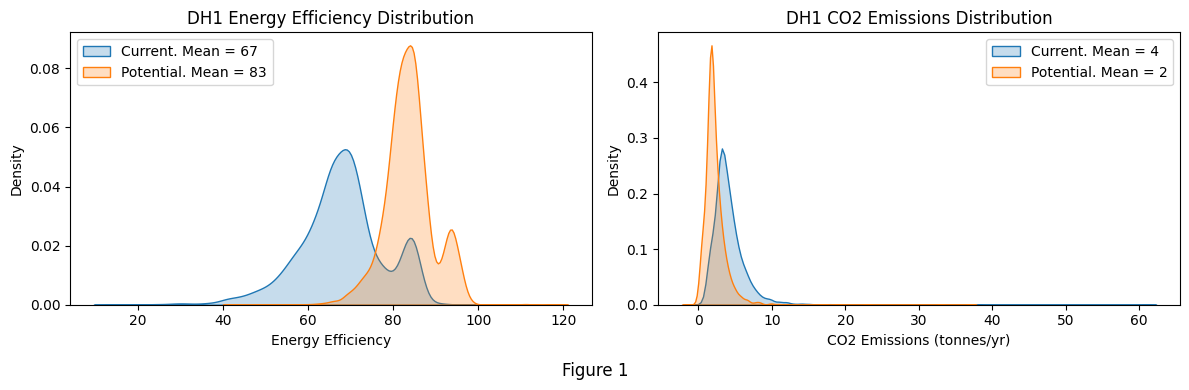

In [72]:
# Create a figure with a specific size
plt.figure(figsize=(12, 4))  # Adjust overall width and height to make plots smaller

# First subplot for CURRENT_ENERGY_EFFICIENCY
plt.subplot(1, 2, 1)  # (rows, columns, index)
sns.kdeplot(certificates['CURRENT_ENERGY_EFFICIENCY'], shade=True,
            label='Current. Mean = ' +
            str(int(np.mean(certificates['CURRENT_ENERGY_EFFICIENCY']))))

sns.kdeplot(certificates['POTENTIAL_ENERGY_EFFICIENCY'], shade=True,
            label='Potential. Mean = ' +
            str(int(np.mean(certificates['POTENTIAL_ENERGY_EFFICIENCY']))))

plt.title('DH1 Energy Efficiency Distribution')
plt.xlabel('Energy Efficiency')
plt.ylabel('Density')
plt.legend(loc='upper left')



# Second subplot for POTENTIAL_ENERGY_EFFICIENCY
plt.subplot(1, 2, 2)

sns.kdeplot(certificates['CO2_EMISSIONS_CURRENT'], shade=True,
            label='Current. Mean = ' +
            str(int(np.mean(certificates['CO2_EMISSIONS_CURRENT']))))

sns.kdeplot(certificates['CO2_EMISSIONS_POTENTIAL'], shade=True,
            label='Potential. Mean = ' +
            str(int(np.mean(certificates['CO2_EMISSIONS_POTENTIAL']))))

plt.title('DH1 CO2 Emissions Distribution')
plt.xlabel('CO2 Emissions (tonnes/yr)')
plt.ylabel('Density')
plt.legend(loc='upper right')

# Add Figure 1 text between the subplots
plt.figtext(0.5, 0.01, 'Figure 1', ha='center', va='center', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plots
plt.show()

There are a few insights here. The first, is that I empirically derived approximations for the mean current and potential Energy Efficiency of DH1 (which is stated in the first text block above) to a 95%+ accuracy. This is an indicator that our data cleansing methods are sound and introduce little to no bias.

Another insight is that the energy efficiency scores are becoming more consistent across the dataset, which is beneficial as the mean is moving towards higher efficiency, indicating widespread improvements. For CO2 emissions, the potential emissions distribution is narrower than the current, demonstrating a uniform reduction across the board, which is a positive development in environmental impact efforts.

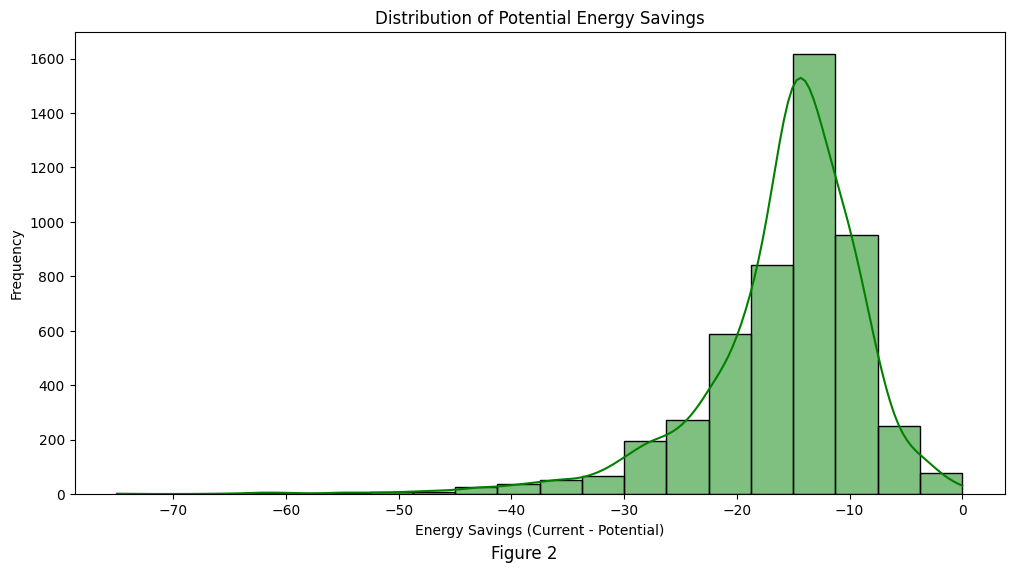

In [73]:
# Calculate potential energy savings
certificates['ENERGY_SAVINGS'] = certificates['CURRENT_ENERGY_EFFICIENCY'] - certificates['POTENTIAL_ENERGY_EFFICIENCY']

# Plot the distribution of energy savings
plt.figure(figsize=(12, 6))
sns.histplot(certificates['ENERGY_SAVINGS'], kde=True, bins=20, color='green')
plt.title('Distribution of Potential Energy Savings')
plt.xlabel('Energy Savings (Current - Potential)')
plt.ylabel('Frequency')
plt.figtext(0.5, 0.01, 'Figure 2', ha='center', va='center', fontsize=12)
plt.show()

The figure illustrates the distribution of potential energy savings for various properties, calculated as the difference between current and potential energy efficiency ratings. The histogram shows that the majority of properties have potential energy savings in the range of -10 to -20, with the most common savings highlighted by the peak of the green KDE line. The distribution is right-skewed, indicating that while many properties can achieve moderate improvements, a few have significantly higher potential savings. The spread of data shows a concentration of properties with savings from -10 to -30, and fewer properties with extreme savings. This suggests that most properties can achieve some improvement in energy efficiency, but a few have substantial room for enhancement.

## **III** Optimal Client Case Study

I choose _the optimal client_ simply based on highest descrepency between current energy efficiency and potential energy efficiency (i.e highest $\Delta$). In reality, there are a lot more factors to consider such as the client's commitment, financial situation, etc. However, in this basic theoretical scenario, the delta acts as a metric for "how much improvement could be done".

The optimal client turns out to be house ID `1124593071032020091516204666078406`, as I will show below.

Given that I have already sorted the dataframe by highest to lowest delta, the optimal client is simply the first row of the dataframe.

In [74]:
optimal_client = cert_cleaned.iloc[0] #Getting the optimal client using the above method
optimal_client

LMK_KEY                                           1124593071032020091516204666078406
ADDRESS1                                                            3 Beaumont Court
ADDRESS2                                                                   Bank Foot
ADDRESS3                                                                  Shincliffe
POSTCODE                                                                     DH1 2PD
BUILDING_REFERENCE_NUMBER                                                 7616412278
CURRENT_ENERGY_RATING                                                              G
POTENTIAL_ENERGY_RATING                                                            B
CURRENT_ENERGY_EFFICIENCY                                                         15
POTENTIAL_ENERGY_EFFICIENCY                                                       90
IMPROVEMENT_DELTA                                                                 75
PROPERTY_TYPE                                                    

As mentioned in the output of the above cell, the optimal client is a Semi-Detached, marketed sale house. They are currently a G rating (15 eff) but have potential to reach a B rating (90 eff).

### KPI Before and After

The data above indicates that this home is heavily below both potential and demographic standards with mutliple factors stating Poor to Very Poor performance. This fact motivates the visualization below (fig.3), a Grouped Bar Chart that shows the difference in the following high level metrics: CO2 Emissions, Enviromental Impact, and Energy Efficiency.




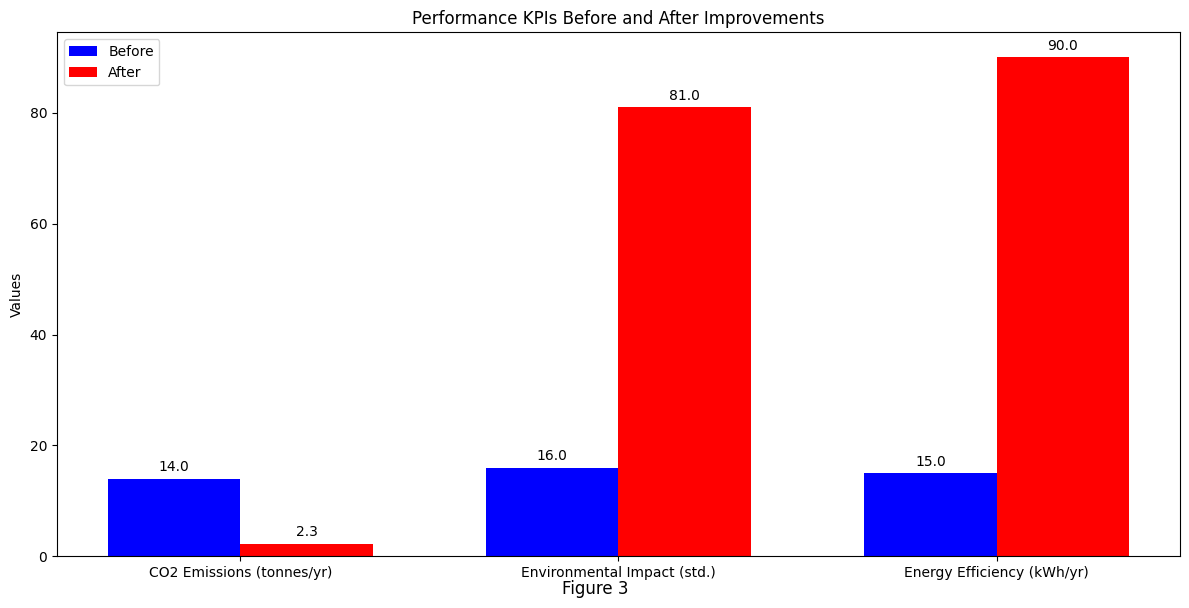

In [75]:

# Sample data based on provided variables
client_eng_effic = [optimal_client["CURRENT_ENERGY_EFFICIENCY"], optimal_client["POTENTIAL_ENERGY_EFFICIENCY"]]
client_co2_emission = [optimal_client["CO2_EMISSIONS_CURRENT"], optimal_client["CO2_EMISSIONS_POTENTIAL"]]
client_env_impact = [optimal_client["ENVIRONMENT_IMPACT_CURRENT"], optimal_client["ENVIRONMENT_IMPACT_POTENTIAL"]]

# Combining the data for grouped bar chart
labels = ['CO2 Emissions (tonnes/yr)', 'Environmental Impact (std.)', 'Energy Efficiency (kWh/yr)']
before_values = [client_co2_emission[0], client_env_impact[0], client_eng_effic[0]]
after_values = [client_co2_emission[1], client_env_impact[1], client_eng_effic[1]]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, before_values, width, label='Before',color='b')
rects2 = ax.bar(x + width/2, after_values, width, label='After',color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Performance KPIs Before and After Improvements')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to attach a text label above each bar, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.figtext(0.5, 0.01, 'Figure 3', ha='center', va='center', fontsize=12)
fig.tight_layout()

plt.show()

The grouped bar chart compares the performance KPIs before and after improvements, showing a reduction in CO2 emissions by approximately 83.6%, an increase in environmental impact by 406.3%, and an increase in energy efficiency by 500%.

I chose this plotting style because it's a simple to understand, visual representation of the effects. This is likely something a client can understand, and if government incentives become powerful and widespread, might even be a plot a client would be curious to see.


### Client Cost Savings

The next plots are designed to show the financial effect of the improvements, also at the client level.

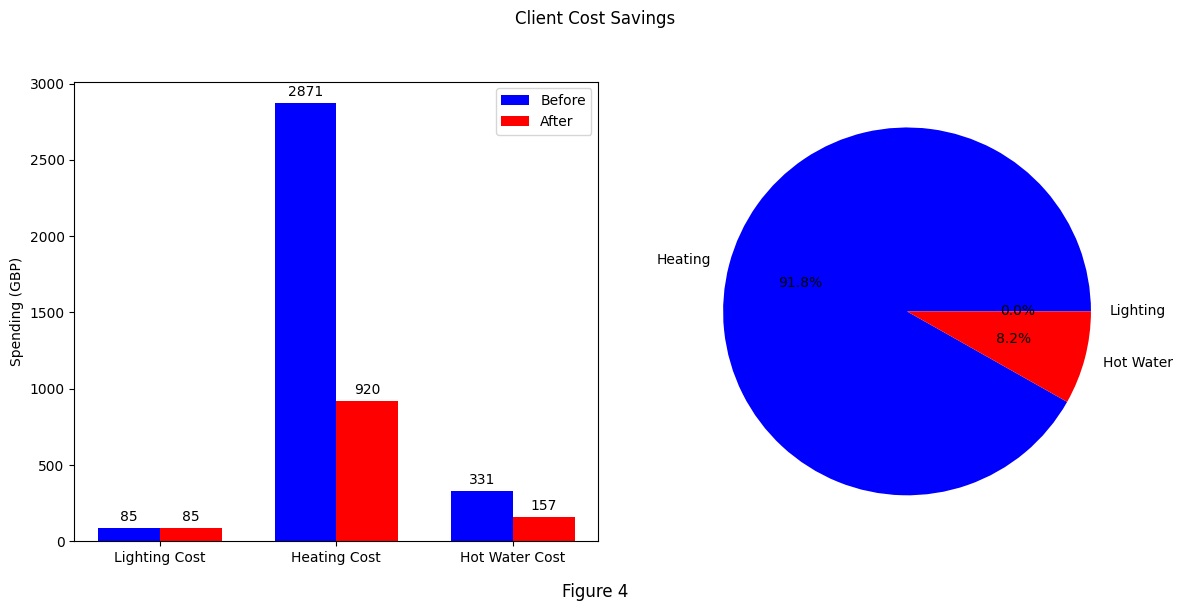

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Client Cost Savings')

# Sample data based on provided variables
client_light_cost = [optimal_client["LIGHTING_COST_CURRENT"], optimal_client["LIGHTING_COST_POTENTIAL"]]
client_heat_cost = [optimal_client["HEATING_COST_CURRENT"], optimal_client["HEATING_COST_POTENTIAL"]]
client_hotWater_cost = [optimal_client["HOT_WATER_COST_CURRENT"], optimal_client["HOT_WATER_COST_POTENTIAL"]]

# Combining the data for grouped bar chart
labels = ['Lighting Cost', 'Heating Cost', 'Hot Water Cost']
before_values = [client_light_cost[0], client_heat_cost[0], client_hotWater_cost[0]]
after_values = [client_light_cost[1], client_heat_cost[1], client_hotWater_cost[1]]


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax1.bar(x - width/2, before_values, width, label='Before',color='b')
rects2 = ax1.bar(x + width/2, after_values, width, label='After',color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Spending (GBP)')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

# Function to attach a text label above each bar, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Add Figure 1 text between the subplots
plt.figtext(0.5, 0.01, 'Figure 4', ha='center', va='center', fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

labels = 'Lighting', 'Heating', 'Hot Water', #labels for pie chart

pie_func = lambda x: x[0] - x[1] if x[0] - x[1] >= 0 else 0 #function that maps the cost datasets above to the amount saved

sizes = [pie_func(client_light_cost), pie_func(client_heat_cost), pie_func(client_hotWater_cost)] #size of the inputs of the pie chart

plt.pie(sizes,labels=labels, colors=['g','b','r'],autopct='%1.1f%%') #pie chart

plt.show()





As shown above, there are very powerful financial savings, resulting in a total of 1162 GBP considering the three factors above. The main source of savings comes from heating (~91,8% of savings), and the rest goes to Hot Water (at ~8,2%). The only component that has the same result at 85GBP.


In [77]:
recommendations.head()

,LMK_KEY,IMPROVEMENT_ITEM,IMPROVEMENT_SUMMARY_TEXT,IMPROVEMENT_DESCR_TEXT,IMPROVEMENT_ID,IMPROVEMENT_ID_TEXT,INDICATIVE_COST
0,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,1,Room-in-roof insulation,Room-in-roof insulation,46.0,NaN,"£1,500 - £2,700"
1,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,2,Internal or external wall insulation,Internal or external wall insulation,7.0,NaN,"£4,000 - £14,000"
2,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,3,Floor insulation (suspended floor),Floor insulation (suspended floor),57.0,NaN,"£800 - £1,200"
3,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,4,Draught proofing,Draught proofing,10.0,NaN,£80 - £120
4,1102c41bd05263fff88345b7ed34b1de5c02652117f05dc6bbd0dd21a23dc022,5,Solar water heating,Solar water heating,19.0,NaN,"£4,000 - £6,000"


In [78]:
# Filter the recommendations for the optimal client
client_recommendations = recommendations[recommendations['LMK_KEY'] == '1124593071032020091516204666078406']

# Print the column of IMPROVEMENT_SUMMARY_TEXT
print("Improvement Summary for Optimal Client:")
print("----------------------------------------")
for summary in client_recommendations['IMPROVEMENT_SUMMARY_TEXT']:
  print(summary)


Improvement Summary for Optimal Client:
----------------------------------------
Room-in-roof insulation
Internal or external wall insulation
Floor insulation (solid floor)
Heating controls (programmer, room thermostat and TRVs)
Solar water heating
Replacement glazing units
Solar photovoltaic panels, 2.5 kWp
Wind turbine


In [79]:
import pandas as pd
import re

# Filter the recommendations for the optimal client
df_client_recommendations = recommendations[recommendations['LMK_KEY'] == '1124593071032020091516204666078406']


# Print the column of INDICATIVE_COST
print("Indicative Costs for Optimal Client:")
print("----------------------------------")
for cost in df_client_recommendations['INDICATIVE_COST']:
    print(cost)

# Function to parse cost range
def parse_cost_range(cost_range):
    match = re.match(r"£(\d{1,3}(?:,\d{3})*) - £(\d{1,3}(?:,\d{3})*)", cost_range)
    if match:
        lower = int(match.group(1).replace(",", ""))
        upper = int(match.group(2).replace(",", ""))
        return lower, upper
    else:
        raise ValueError("Cost range format is incorrect")

# Calculate total indicative cost range
total_lower = 0
total_upper = 0

for cost in df_client_recommendations['INDICATIVE_COST']:
    lower, upper = parse_cost_range(cost)
    total_lower += lower
    total_upper += upper

# Format the total cost range
total_cost_range = f"£{total_lower:,} - £{total_upper:,}"

print("----------------------------------")
print(f"Total Indicative Cost: {total_cost_range}")


Indicative Costs for Optimal Client:
----------------------------------
£1,500 - £2,700
£4,000 - £14,000
£4,000 - £6,000
£350 - £450
£4,000 - £6,000
£1,000 - £1,400
£3,500 - £5,500
£15,000 - £25,000
----------------------------------
Total Indicative Cost: £33,350 - £61,050


As part of my analysis, I focused on the property identified by LMK_KEY = `1124593071032020091516204666078406` because it had the highest potential improvement delta. Implementing the recommended energy efficiency measures—including cavity wall insulation, floor insulation (suspended floor), high heat retention storage heaters and a dual immersion cylinder, solar water heating, and solar photovoltaic panels with a capacity of 2.5 kWp—could elevate the property's energy rating from G to B. The estimated cost for these upgrades ranges between £33,350 and £61,050. This significant improvement underscores the value of targeted energy efficiency investments.

### Addendum

I was also curious to see if an age of a house has any affect on the energy efficiency improvment

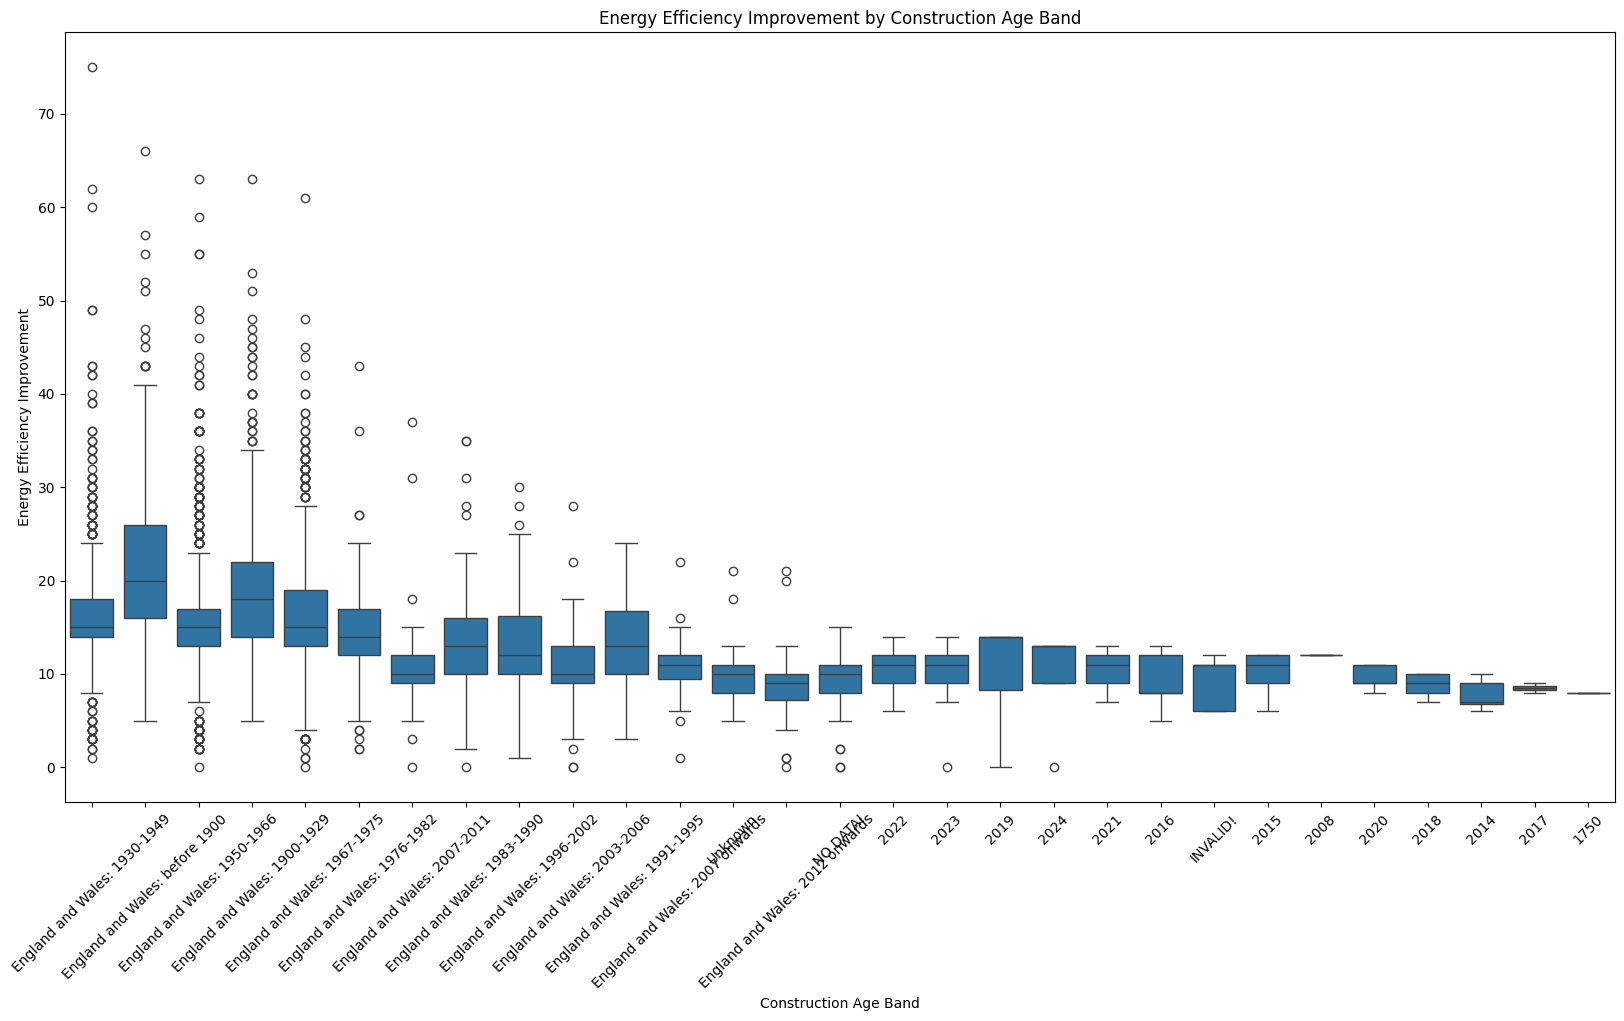

In [80]:
plt.figure(figsize=(20, 10))

# Calculate energy efficiency improvement
cert_cleaned['EFFICIENCY_IMPROVEMENT'] = cert_cleaned['POTENTIAL_ENERGY_EFFICIENCY'] - cert_cleaned['CURRENT_ENERGY_EFFICIENCY']

# Boxplot for energy efficiency improvement by construction age band
sns.boxplot(x='CONSTRUCTION_AGE_BAND', y='EFFICIENCY_IMPROVEMENT', data=cert_cleaned)
plt.title('Energy Efficiency Improvement by Construction Age Band')
plt.xticks(rotation=45)
plt.xlabel('Construction Age Band')
plt.ylabel('Energy Efficiency Improvement')
plt.show()

This figure presents the potential for energy efficiency improvements across various construction age bands using a boxplot. Older properties, such as those built between 1900-1929, exhibit higher median values and a broader range of potential improvements, indicating substantial variability and opportunity for enhancement. If we look at it in another angle, newer properties, constructed post-2012, show lower median values and smaller interquartile ranges, reflecting limited room for improvement due to higher existing efficiency standards. The presence of significant outliers in older buildings suggests targeted interventions could be highly beneficial.

Policy recommendations include prioritizing retrofitting older buildings, enhancing data accuracy, and addressing properties with exceptionally high improvement potential to maximize energy efficiency outcomes